# Early Data Analysis
Interpreting data from `batch_analyse.py`. The aim is to filter out the dataset to the required properties to explore potential exocomet-type transits.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import glob

In [2]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


---

In [3]:
with open('output_xrp.txt') as f:
    lines = f.readlines()

In [4]:
lc_lists = [word for line in lines for word in line.split()]
lc_lists = [lc_lists[i:i+10] for i in range(0, len(lc_lists), 10)]

---

## Creating DataFrame
- data used is `corrected flux`, not PCA.

In [5]:
cols = ['file','signal','signal/noise','time','asym_score','width1','width2','duration','depth','transit_prob']
df = pd.DataFrame(data=lc_lists,columns=cols)
df[cols[1:-1]] = df[cols[1:-1]].astype('float32')

In [6]:
df['transit_prob'].unique()

array(['maybeTransit', 'end', 'point', 'artefact'], dtype=object)

### Filtered DataFrame

Parameters filtered:
- `signal/noise` greater than 5.
    - Minimum test statistic is always negative. We flip the sign in our plots for convenience.
- `asym_score` greater than 1.0
- `transit_prob` set to `maybeTransit` only.

In [7]:
filtered_df = df[(df['signal/noise'] <= -5.0) & (df['asym_score'] >= 1.0) & (df['transit_prob'] == 'maybeTransit')]

In [8]:
filtered_df['file'].head()

13     tesslc_33107833.pkl
18    tesslc_715998838.pkl
26     tesslc_24722209.pkl
57    tesslc_300739338.pkl
61     tesslc_32761595.pkl
Name: file, dtype: object

In [9]:
filtered_df['file'].iloc[0]

'tesslc_33107833.pkl'

Filtering again for rough analysis. This time:
- `duration` set to greater than 0.5 days.
- `asym_score` between 1.06 to 1.9.

In [10]:
filtered_df[(filtered_df.duration >= 0.500) & (filtered_df['signal/noise'] <= -5.0) & (filtered_df['asym_score'] >= 1.06) & (filtered_df['asym_score'] <= 1.9)].head()

,file,signal,signal/noise,time,asym_score,width1,width2,duration,depth,transit_prob
57,tesslc_300739338.pkl,-11.406204,-5.626895,1480.989746,1.105723,0.352566,0.029577,0.541675,-0.000620,maybeTransit
1140,tesslc_247714994.pkl,-14.944496,-5.909526,1473.412476,1.101007,0.025844,0.300981,0.562491,-0.001284,maybeTransit
8206,tesslc_124922223.pkl,-12.796556,-7.097831,1476.159790,1.071094,0.454916,0.024216,0.916668,-0.004627,maybeTransit
9682,tesslc_80598364.pkl,-15.981009,-6.483171,1473.412354,1.100286,0.021821,0.355905,0.583324,-0.008912,maybeTransit
10980,tesslc_271725494.pkl,-10.697904,-5.711776,1476.551758,1.079464,0.257631,0.013382,0.500006,-0.009612,maybeTransit


---

### Raw Plot - sample size 846k

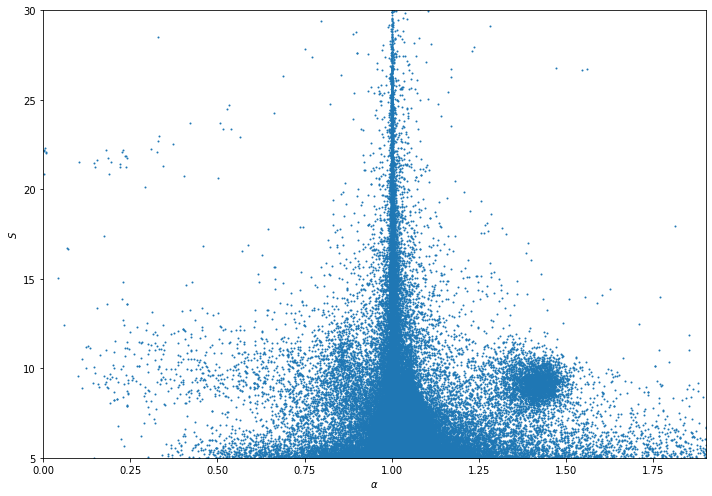

In [11]:
def distribution(x,y):

    fig,ax = plt.subplots(figsize=(10,7))
    ax.scatter(x,y,s=1)
    ax.set_xlim(0,1.9)
    ax.set_ylim(5,30)
    ax.set_xlabel('$\\alpha$')
    ax.set_ylabel('$S$')
    fig.tight_layout()

distribution(df.asym_score,abs(df['signal/noise']))

### `MaybeTransit` only - sample size 846k

In [12]:
import matplotlib.patches as patches

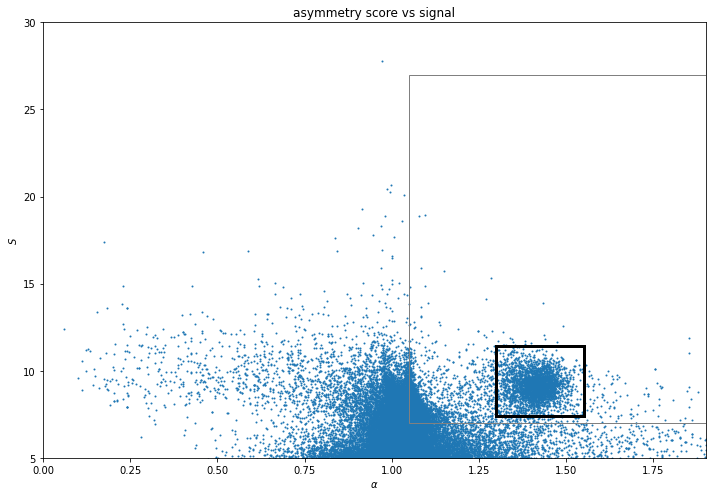

In [13]:
fig,ax = plt.subplots(figsize=(10,7))
ax.scatter(df.asym_score[df.transit_prob == 'maybeTransit'],abs(df['signal/noise'][df.transit_prob == 'maybeTransit']),s=1)
ax.set_xlim(0,1.9)
ax.set_ylim(5,30)
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$S$')
ax.set_title('asymmetry score vs signal')
fig.tight_layout()
rect = patches.Rectangle((1.30, 7.40), 0.25, 4, linewidth=3, edgecolor='k', facecolor='none')
interest_region = patches.Rectangle((1.05,7),3,20, linewidth=1,edgecolor='grey',facecolor='none') # region of interest in Kennedy et al
ax.add_patch(rect)
ax.add_patch(interest_region)
plt.show()

Next steps - apply a feature that distinguishes false positives, EB's, etc.

---

### Exploring that black boxed region

Create our box with the following settings:
- `signal/noise` between 7.4 and 12
- `asym_score` between 1.3 and 1.6

In [14]:
box = df[(df['signal/noise'] <= -7.4) & (df['asym_score'] >= 1.30) & (df['transit_prob'] == 'maybeTransit') & (df['asym_score'] <= 1.60) & (df['signal/noise'] >= -12)]

In [15]:
to_import = box['file'].head(15)

In [16]:
import tqdm as tqdm
import os
from analysis_tools_cython import *

In [17]:
sector = 6
path = '/storage/astro2/phrdhx/tesslcs'

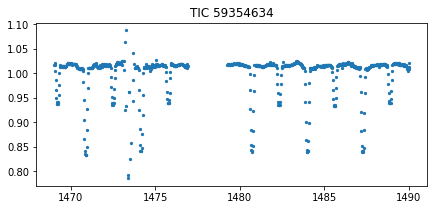

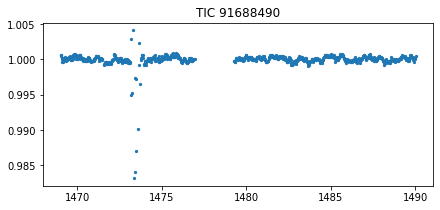

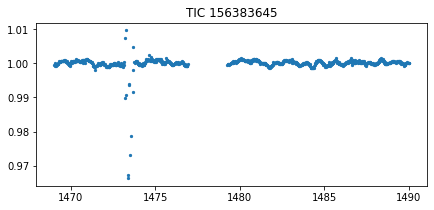

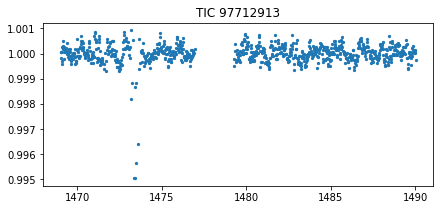

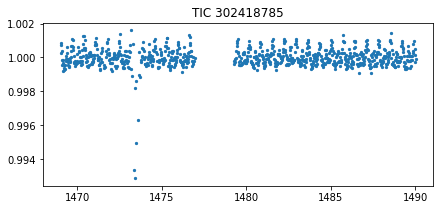

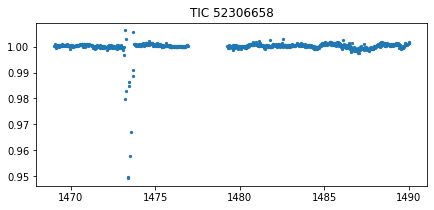

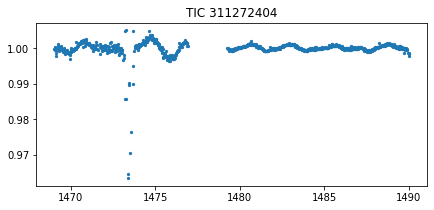

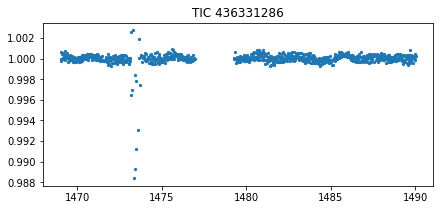

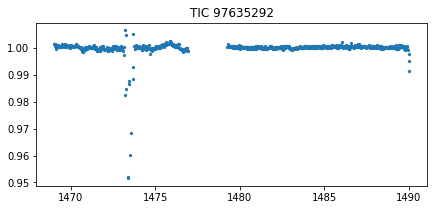

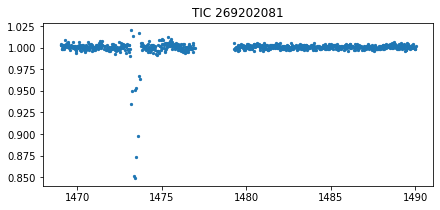

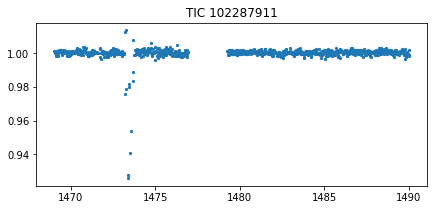

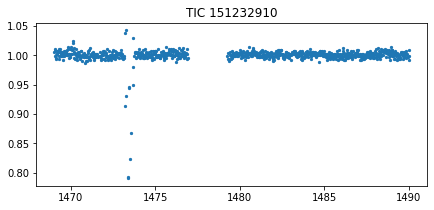

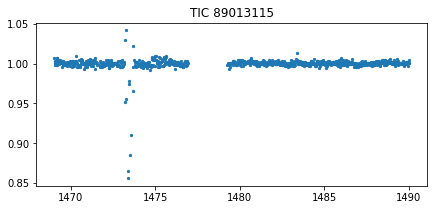

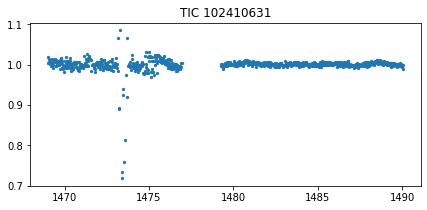

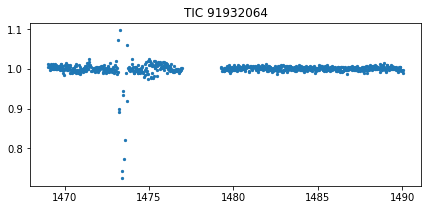

In [18]:
for i in to_import:
    file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
    table = import_XRPlightcurve(file_paths,sector=sector)[0]
    fig,ax = plt.subplots(figsize=(7,3))
    TIC_ID = file_paths.split('_')[-1][:-4]
    ax.scatter(table['time'],normalise_lc(table['corrected flux']),s=5)
    ax.set_title(f'TIC {TIC_ID}')
    plt.show()
    #plt.savefig(f'figs_tess/output_analysis/lightcurve {lc_info[0]} at import')